# Reproducible Deep Learning Experiment: Land Use Classification with EuroSAT

This notebook demonstrates a fully reproducible deep learning pipeline using the EuroSAT dataset—a benchmark of Sentinel-2 satellite images for land use classification introduced by Helber et al. (2019) [^1]. Our goal is to present an end-to-end workflow covering data acquisition, preprocessing, model training, and evaluation, all encapsulated within a reproducible containerized environment. By following best practices such as version control and Infrastructure as Code, this demo project enables others to easily replicate and extend the experiment.

![EuroSAT Dataset Overview](https://raw.githubusercontent.com/phelber/EuroSAT/refs/heads/master/eurosat_overview_small.jpg)

[^1]: P. Helber, B. Bischke, A. Dengel and D. Borth, "EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification," in IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, vol. 12, no. 7, pp. 2217-2226, July 2019, doi: 10.1109/JSTARS.2019.2918242.


In [1]:
import os
import ssl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import EuroSAT
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# set a seed for the experiment's repeatability, thus ACM's R1
RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Enforce deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# change directory
if not os.path.exists("Finetune_ResNet.ipynb"):
    os.chdir("src")
assert os.path.exists("Finetune_ResNet.ipynb")

# Check if cuda can access the GPU via CUDA drivers
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Select device '{device}'")

True
Select device 'cuda'


In [2]:
# paths for saving results
RESULT_FILE = "ResNet_results.csv"
MODEL_FILE = "model.pt"
PATH_DATA = "../data"

# hyperparameters
N_EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001

## Load a pretrained ResNet model

Init a ResNet18 model with pre-trained weights using PyTorch’s `torchvision.models` library.
See the [PyTorch documentation on initializing pretrained models](https://pytorch.org/vision/main/models.html#initializing-pre-trained-models) for more information.

In [3]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Adapt the Final Layer and Freeze all but the last layers


The last fully connected layer of ResNet18 is designed to output 1,000 classes by default (as it is trained on ImageNet). Since EuroSAT has only 10 classes, we need to replace this layer.
To retain the general feature-extracting capabilities of the pre-trained network, we freeze the weights of the earlier layers. This prevents them from being updated during training.

In [4]:
# replace the final linear layer (fc)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)  # EuroSAT has 10 classes

# freeze all but the final layer
for param in model.parameters():
    param.requires_grad = False

# Only the final fc layer’s parameters will be updated
for param in model.fc.parameters():
    param.requires_grad = True

## Load the Dataset

Load the EuroSAT dataset using `torchvision.datasets` with an appropriate transformation.

In [5]:
# Resize and use source-specific mean and std for normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a context that disables certificate verification to allow downloading the dataset
ssl._create_default_https_context = ssl._create_unverified_context

# Load the EuroSAT dataset
dataset = EuroSAT(root=PATH_DATA, transform=transform, download=True)

# It's highly recommended to re-enable certificate verification after downloading
ssl._create_default_https_context = ssl.create_default_context

## Train-Test Split

Here, we want to use only 10 % of all training instances to decrease the time for computation. 
Additionally, the dataset is split into 80 % training and 20 % validation instances. The number of images for each dataset is printed.

In [6]:
# Only use 10 % of the dataset to decrease the runtime here
dataset_sub = torch.utils.data.Subset(
    dataset, np.random.permutation(len(dataset))[:int(len(dataset)*0.1)]
)

# Split dataset into 80 % training and 20 % validation images
train_size = int(0.8 * len(dataset_sub))
val_size = len(dataset_sub) - train_size
train_dataset, val_dataset = random_split(dataset_sub, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)

print(f"Sizes of train/val datasets: {len(train_dataset)} / {len(val_dataset)}")

Sizes of train/val datasets: 2160 / 540


## Define Model Training

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


def train_and_validate(n_epochs, model, train_loader, val_loader, optimizer, criterion, verbose=1):
    """
    Train and validate a neural network model over a specified number of epochs.

    Args:
        n_epochs (int): Number of epochs for training.
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        criterion (torch.nn.Module): Loss function to compute training loss.
        verbose (int): Verbosity level; higher numbers print more details.

    Returns:
        tuple: The trained model and two lists containing training and validation accuracies per epoch.
    """
    train_accs = []
    val_accs = []

    # move the model to the device
    model = model.to(device)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # aggregate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_acc = 100.0 * correct_train / total_train  # in percentage
        train_accs.append(train_acc)

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_acc = 100.0 * correct_val / total_val  # in percentage
        val_accs.append(val_acc)

        if verbose >= 1:
            print(
                f"Epoch [{epoch + 1}/{n_epochs}], "
                f"Loss: {running_loss / len(train_loader):.4f}, "
                f"Training Accuracy: {train_acc:.2f} %, "
                f"Validation Accuracy: {val_acc:.2f} %"
            )

    return model, train_accs, val_accs

## Train the Model

In [8]:
# Train and validate the model
model, train_accs, val_accs = train_and_validate(
    train_loader=train_loader, val_loader=val_loader,
    optimizer=optimizer, criterion=criterion,
    model=model, n_epochs=N_EPOCHS, verbose=1
)

Epoch [1/10], Loss: 2.1623, Training Accuracy: 22.08 %, Validation Accuracy: 48.89 %
Epoch [2/10], Loss: 1.5578, Training Accuracy: 57.73 %, Validation Accuracy: 68.15 %
Epoch [3/10], Loss: 1.1513, Training Accuracy: 75.00 %, Validation Accuracy: 76.11 %
Epoch [4/10], Loss: 0.9030, Training Accuracy: 81.85 %, Validation Accuracy: 79.63 %
Epoch [5/10], Loss: 0.7531, Training Accuracy: 84.77 %, Validation Accuracy: 82.78 %
Epoch [6/10], Loss: 0.6467, Training Accuracy: 86.48 %, Validation Accuracy: 83.70 %
Epoch [7/10], Loss: 0.5804, Training Accuracy: 87.41 %, Validation Accuracy: 84.63 %
Epoch [8/10], Loss: 0.5211, Training Accuracy: 88.47 %, Validation Accuracy: 84.81 %
Epoch [9/10], Loss: 0.4857, Training Accuracy: 88.43 %, Validation Accuracy: 86.48 %
Epoch [10/10], Loss: 0.4472, Training Accuracy: 89.72 %, Validation Accuracy: 86.11 %


In [9]:
# The epoch-wise results to reproduce are listed below:
# Epoch [1/10], Loss: 2.1624, Training Accuracy: 22.04%, Validation Accuracy: 48.89%
# Epoch [2/10], Loss: 1.5579, Training Accuracy: 57.73%, Validation Accuracy: 68.15%
# Epoch [3/10], Loss: 1.1514, Training Accuracy: 74.95%, Validation Accuracy: 76.11%
# Epoch [4/10], Loss: 0.9031, Training Accuracy: 81.85%, Validation Accuracy: 79.63%
# Epoch [5/10], Loss: 0.7532, Training Accuracy: 84.81%, Validation Accuracy: 82.78%
# Epoch [6/10], Loss: 0.6467, Training Accuracy: 86.48%, Validation Accuracy: 83.70%
# Epoch [7/10], Loss: 0.5804, Training Accuracy: 87.36%, Validation Accuracy: 84.63%
# Epoch [8/10], Loss: 0.5212, Training Accuracy: 88.47%, Validation Accuracy: 84.81%
# Epoch [9/10], Loss: 0.4857, Training Accuracy: 88.43%, Validation Accuracy: 86.48%
# Epoch [10/10], Loss: 0.4472, Training Accuracy: 89.72%, Validation Accuracy: 86.11%

In [10]:
# Save the results to the specified file
result_df = pd.DataFrame(
    {"train_accs": train_accs, "val_accs": val_accs},
    index=np.arange(1, N_EPOCHS + 1)
)
result_df.to_csv(RESULT_FILE, index_label="Epoch")
result_df.head(10)

,train_accs,val_accs
1,22.083333,48.888889
2,57.731481,68.148148
3,75.000000,76.111111
4,81.851852,79.629630
5,84.768519,82.777778
6,86.481481,83.703704
7,87.407407,84.629630
8,88.472222,84.814815
9,88.425926,86.481481
10,89.722222,86.111111


In [11]:
# save PyTorch model
torch.save(model.to("cpu"), MODEL_FILE)

## Visualizations

Plot the training progress and a confusion matrix of our model's prediction.

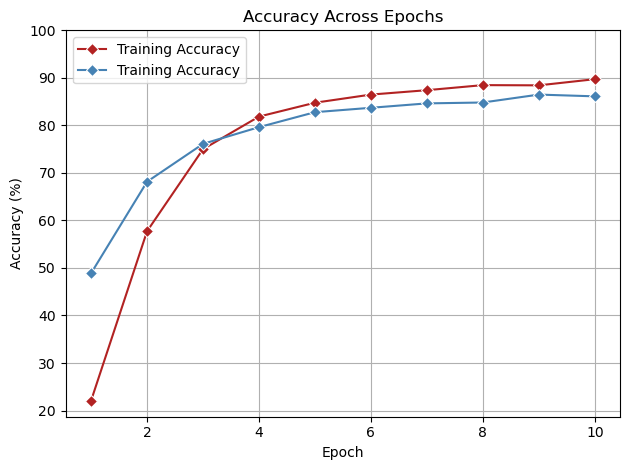

In [12]:
# Plot the lines
sns.lineplot(result_df["train_accs"], color="firebrick", marker="D", linestyle="-", label="Training Accuracy")
sns.lineplot(result_df["val_accs"], color="steelblue", marker="D", linestyle="-", label="Training Accuracy")

# Customise plot
plt.title("Accuracy Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(None, 100)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [13]:
# Fetch all classes of the validation dataset
val_true = list()
val_preds = list()
_ = model.eval()  # set model to evaluation mode (important when using e.g. dropouts)
with torch.no_grad():
    for images, labels in val_loader:
        val_true += list(labels.numpy())
        outputs = model.to(device)(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        val_preds += list(predicted.to("cpu").numpy())

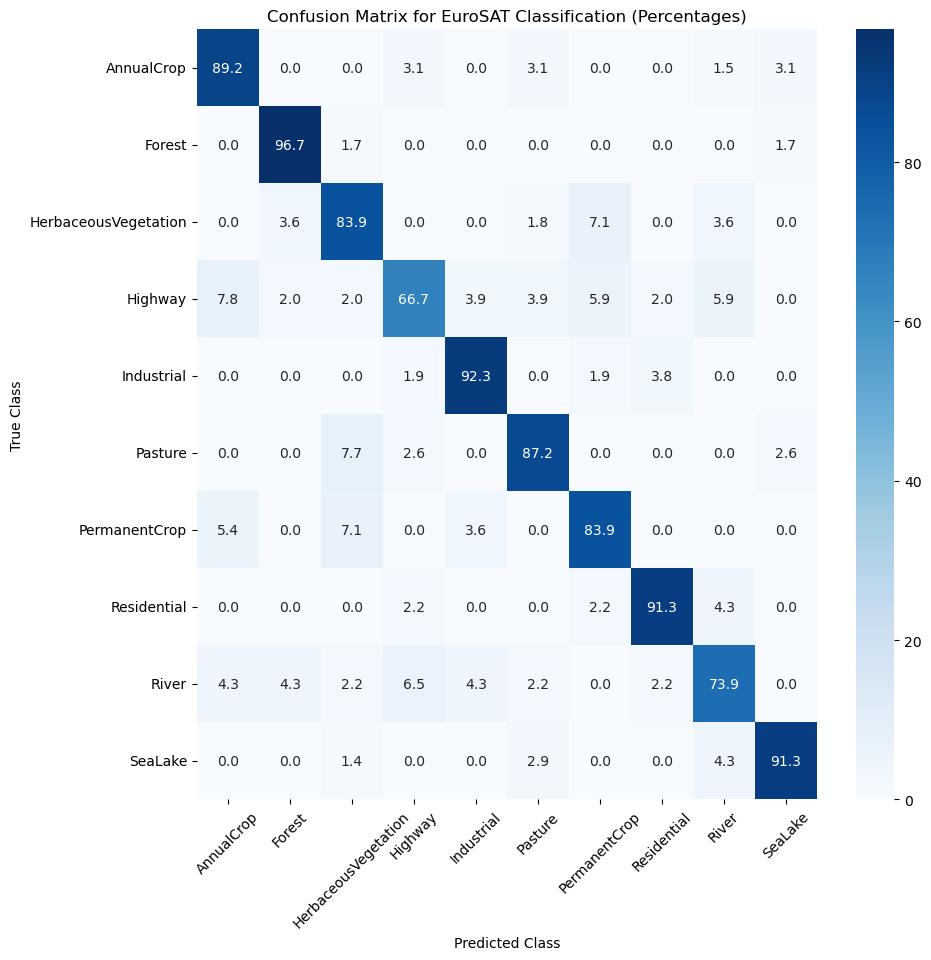

In [14]:
# Generate the confusion matrix and normalize it to percentages
conf_matrix = confusion_matrix(val_true, val_preds, normalize="true") * 100  # Normalized to show percentages

# Define class names based on EuroSAT's 10 classes
class_names = dataset.classes  # EuroSAT class labels

# Plot the confusion matrix with percentage values using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Customizing axis and titles
plt.title("Confusion Matrix for EuroSAT Classification (Percentages)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

The confusion matrix is dominated by its diagonal entries, reflecting high overall classification accuracy.
The most frequent misclassification occurred when permanent highways were incorrectly identified as AnnualCrop, accounting for 7.8 % of all highways.